# TEXT

1. Import thư viện

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
from google.colab import files
upload = files.upload()

Saving spam_or_not_spam.csv to spam_or_not_spam.csv


# Đọc dữ liệu

In [ ]:
df = pd.read_csv('spam_or_not_spam.csv')
df.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


Kiểm tra dữ liệu

In [ ]:
df.tail()

,email,label
2995,abc s good morning america ranks it the NUMBE...,1
2996,hyperlink hyperlink hyperlink let mortgage le...,1
2997,thank you for shopping with us gifts for all ...,1
2998,the famous ebay marketing e course learn to s...,1
2999,hello this is chinese traditional 子 件 NUMBER世...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


# 2. Tiền xử lý

Kiểm tra và loại bỏ dòng trùng lặp

In [ ]:
# Kiểm tra các dòng trùng lặp
duplicates = df[df.duplicated()]
# In ra các dòng trùng lặp
print(duplicates)
# Kiểm tra số lượng dòng trùng lặp
print(f"Số lượng dòng trùng lặp: {df.duplicated().sum()}")
# Xóa tất cả các dòng trùng lặp
df = df.drop_duplicates()

                                                  email  label
317   i think that this and other articles confuse s...      0
318   i think that this and other articles confuse s...      0
460   i agree with rob i think if the phones and mms...      0
787   a friend in dublin is mailing me the cd which ...      0
1805  use perl daily headline mailer this week on pe...      0
...                                                 ...    ...
2946  we guarantee you signups before you ever pay a...      1
2954   otc newsletter discover tomorrow s winners fo...      1
2963  protect your financial well being purchase an ...      1
2968  lowest rates available for term life insurance...      1
2991   get NUMBER free vhs or dvds click hyperlink h...      1

[127 rows x 2 columns]
Số lượng dòng trùng lặp: 127


In [ ]:
df.isnull().sum()

,0
email,1
label,0


Xử lý NaN

In [ ]:
df = df.dropna(subset=['email'])


In [ ]:
df.isnull().sum()

,0
email,0
label,0


In [ ]:
# Kiểm tra số lượng nhãn
print(df['label'].value_counts())

label
0    2445
1     427
Name: count, dtype: int64


Cân bằng nhãn

In [ ]:
from sklearn.utils import resample

# Tách dữ liệu theo nhãn
df_majority = df[df['label'] == 0]  # Nhãn đa số
df_minority = df[df['label'] == 1]  # Nhãn thiểu số

# Tăng mẫu nhãn thiểu số (upsampling)
df_minority_upsampled = resample(df_minority,
                                 replace=True,               # Lấy mẫu lại với thay thế
                                 n_samples=len(df_majority), # Đưa số lượng nhãn thiểu số bằng nhãn đa số
                                 random_state=42)            # Đảm bảo tái hiện được kết quả

# Kết hợp dữ liệu lại
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Shuffle lại dữ liệu (không bắt buộc nhưng nên làm)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Kiểm tra kết quả
print(df_balanced['label'].value_counts())


label
0    2445
1    2445
Name: count, dtype: int64


Chuyển đổi VB thành chữ thường

In [ ]:
def clean_text(text):
    text = text.lower()  # Chuyển về chữ thường
    text = re.sub(r'\W', ' ', text)  # Loại bỏ các ký tự đặc biệt
    text = re.sub(r'\s+', ' ', text)  # Loại bỏ khoảng trắng thừa
    return text.strip()  # Loại bỏ khoảng trắng ở đầu và cuối

df_balanced['email'] = df_balanced['email'].apply(clean_text)

tải tập data các từ không quan trọng

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

chuyển đổi về dạng nguyên thể

In [ ]:
def preprocess_text(text):
    words = text.split()  # Tách văn bản thành các từ
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatize từ và loại bỏ stopwords
    return ' '.join(words)  # Ghép lại thành chuỗi

In [ ]:
df_balanced['email'] = df_balanced['email'].apply(preprocess_text)  # Áp dụng hàm xử lý cho cột 'Message'

tách nhãn data

In [ ]:
X = df_balanced['email'].values
y = df_balanced['label'].values

Chuyển đổi VB thành Vector từ

In [ ]:
cv = CountVectorizer(max_features=3000)  # Khởi tạo CountVectorizer với tối đa 3000 đặc trưng
X_coun = cv.fit_transform(X).toarray()  # Chuyển đổi toàn bộ cột 'Message' thành vector từ

Train - Test

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_coun, y, test_size=0.2, random_state=42)


# 3. Huấn luyện model

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [ ]:
models = {
    'SVM' : {
        'model' : SVC(),
        'params': {
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'C': [0.05, 1, 10, 100],
            'coef0': [2, 3, 4],
            'degree': [1, 2, 3]
        }
    },
    # 'KNN': {
    #     'model': KNeighborsClassifier(),
    #     'params': {
    #         'n_neighbors': [3, 5, 7],
    #         'weights': ['uniform', 'distance']
    #     }
    # },
    # 'Naive Bayes': {
    #     'model': MultinomialNB(),
    #     'params': {
    #         'alpha': [0.1, 0.5]
    #     }
    # },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 15],
            'min_samples_split': [2, 5, 10]
        }
    }
}

In [ ]:
# Bước 5: Hàm huấn luyện và đánh giá
def train_and_evaluate(model_name, model, params, X_train, Y_train, X_test, Y_test):
    print(f"\n### {model_name} ###")
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
    grid.fit(X_train, Y_train)

    print(f"Best Parameters for {model_name}: {grid.best_params_}")

    y_pred = grid.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(Y_test, y_pred))

    print("\nConfusion Matrix:")
    disp = ConfusionMatrixDisplay.from_estimator(grid, X_test, Y_test)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    return grid.best_estimator_



### SVM ###
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters for SVM: {'C': 100, 'coef0': 2, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       511
           1       0.99      0.99      0.99       467

    accuracy                           0.99       978
   macro avg       0.99      0.99      0.99       978
weighted avg       0.99      0.99      0.99       978


Confusion Matrix:


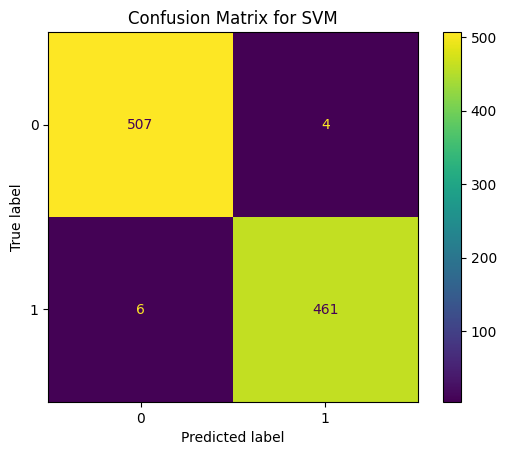


### KNN ###
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for KNN: {'n_neighbors': 3, 'weights': 'distance'}

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       511
           1       0.88      0.99      0.93       467

    accuracy                           0.93       978
   macro avg       0.93      0.93      0.93       978
weighted avg       0.93      0.93      0.93       978


Confusion Matrix:


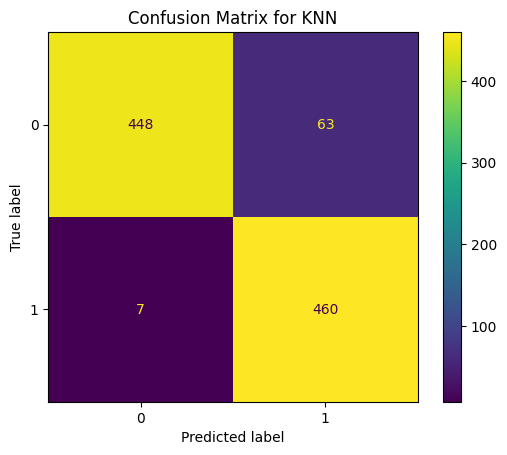


### Naive Bayes ###
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters for Naive Bayes: {'alpha': 0.1}

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       511
           1       0.99      0.97      0.98       467

    accuracy                           0.98       978
   macro avg       0.99      0.98      0.98       978
weighted avg       0.98      0.98      0.98       978


Confusion Matrix:


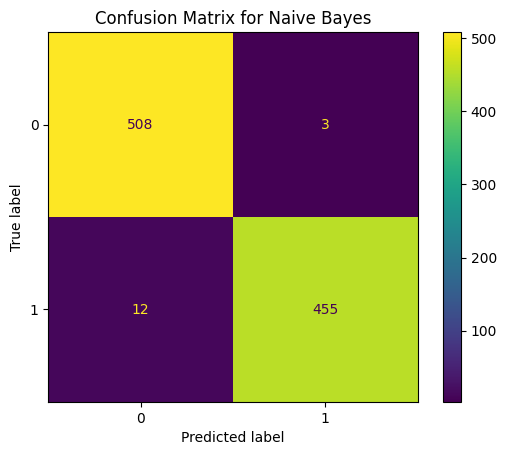


### Decision Tree ###
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 5}

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       511
           1       0.98      0.98      0.98       467

    accuracy                           0.98       978
   macro avg       0.98      0.98      0.98       978
weighted avg       0.98      0.98      0.98       978


Confusion Matrix:


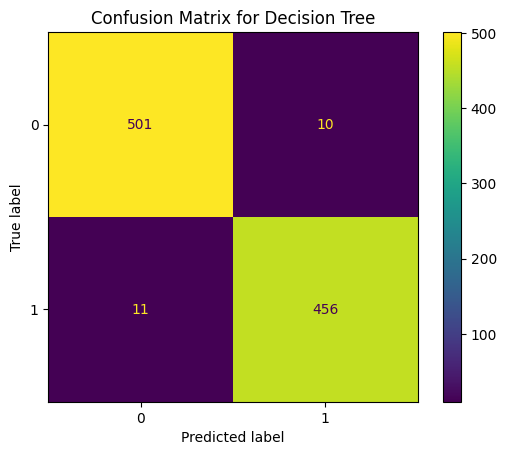

In [ ]:
# Bước 6: Huấn luyện từng mô hình
best_models = {}
for name, config in models.items():
    best_models[name] = train_and_evaluate(name, config['model'], config['params'], X_train, Y_train, X_test, Y_test)

In [ ]:
# Hiển thị kết quả của 10 dòng đầu tiên trong bộ dữ liệu test cho model SVM
svm_model = best_models['SVM']  # Lấy mô hình SVM tốt nhất từ quá trình huấn luyện

# Dự đoán kết quả
y_pred_svm = svm_model.predict(X_test[:10])  # Chỉ lấy 10 dòng đầu tiên trong tập test

# Tạo DataFrame để hiển thị kết quả
test_results_svm = pd.DataFrame({
    'Email': [cv.inverse_transform(X_test[i].reshape(1, -1))[0] for i in range(10)],  # Chuyển đổi vector thành văn bản
    'Actual': Y_test[:10],
    'Predicted': y_pred_svm
})

# Chuyển đổi nhãn số thành dạng 'Ham' hoặc 'Spam'
test_results_svm['Actual'] = test_results_svm['Actual'].map({0: 'Ham', 1: 'Spam'})
test_results_svm['Predicted'] = test_results_svm['Predicted'].map({0: 'Ham', 1: 'Spam'})

# Hiển thị kết quả dự đoán dưới dạng hội thoại
print("\n### Email Classification Dialogue (10 samples) ###\n")
for index, row in test_results_svm.iterrows():
    email_text = " ".join(row['Email'])  # Chuyển tuple thành chuỗi
    email_preview = email_text[:100]  # Lấy 100 ký tự đầu tiên của email
    print(f"Email: {email_preview}...")
    print(f"System: This email is classified as '{row['Predicted']}' (Actual: '{row['Actual']}').\n")



### Email Classification Dialogue (10 samples) ###

Email: click free hyperlink interested offer special trial...
System: This email is classified as 'Spam' (Actual: 'Spam').

Email: actually address agent already apartment arrived begin building button care city code come company c...
System: This email is classified as 'Spam' (Actual: 'Spam').

Email: _______________________________________________ anyone build error file free freshrpms fri get hello...
System: This email is classified as 'Ham' (Actual: 'Ham').

Email: acceptance already also buying changed changing claim consumer continuing could data date default el...
System: This email is classified as 'Ham' (Actual: 'Ham').

Email: _______________________________________________ ability account act behalf block classified client c...
System: This email is classified as 'Ham' (Actual: 'Ham').

Email: absolutely based business click free home hyperlink information life live work...
System: This email is classified as 'Spam' (Actu